In [1]:
import numpy as np
import scipy as sp
import cv2 as cv
import matplotlib.pyplot as plt
import time


# Download data

In [2]:
# Fetch MNIST dataset
from sklearn.datasets import fetch_openml

data_set = 'mnist'

if data_set == 'mnist':
    raw_data = fetch_openml('mnist_784')
    raw_data_x = np.array((raw_data['data']+0.5)/256.0)
    raw_data_y = np.array(raw_data['target'].astype('int8'))
    # separate classes 0 and 1 into a new dataset
    accptbl_cats = (raw_data_y == 0) | (raw_data_y == 1)
    
    raw_data_x = raw_data_x[accptbl_cats]
    raw_data_y = raw_data_y[accptbl_cats]
    num_classes = 2
    img_sz = (28,28)
else:
    assert False

data_dim = raw_data_x.shape[1]

## Split data into training and validation

In [3]:
def display_image(x,lbl=None):
    plt.imshow(x.reshape(img_sz))
    plt.xticks([])
    plt.yticks([])
    if lbl is not None:
        plt.title(lbl)

def split_data(x,y,fracs=[0.8,0.2],seed=0):
    if seed is not None:
        np.random.seed(seed)
    N = x.shape[0]
    rp = np.random.permutation(N)

    N1 = int(fracs[0]*N)
    N2 = min(N-N1,int(fracs[1]*N))

    # Split the data into two parts
    x1 = x[rp[:N1]]
    y1 = y[rp[:N1]]
    x2 = x[rp[N1:(N1+N2)]]
    y2 = y[rp[N1:(N1+N2)]]

    return x1,y1,x2,y2

def onehot_encode(y,num_classes=10):
    """
    Convert an Nx1 vector of integer class labels from 0 to C-1 into 
    an NxC matrix where each row is a one-hot encoding of the 
    """
    return np.eye(num_classes)[y.reshape(-1)]

In [4]:
train_x,train_y,test_x,test_y = split_data(raw_data_x,raw_data_y,fracs=[0.01,0.01])
train_x,train_y,  val_x,val_y = split_data(train_x,train_y,fracs=[0.6,0.4])

In [5]:
print('num_train = ' + str(train_x.shape[0]))
print('num_val = ' + str(val_x.shape[0]))
print('num_test = ' + str(test_x.shape[0]))
print('num_classes = '+str(num_classes))

num_train = 88
num_val = 58
num_test = 147
num_classes = 2


# Explore the data

48.86% of the training data is class 0, corresponding to 43 data points
51.14% of the training data is class 1, corresponding to 45 data points


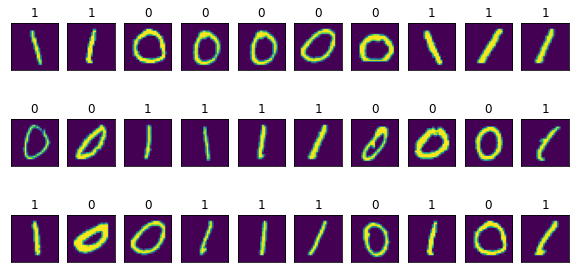

In [6]:
# Print statistics
num_train = len(train_y)
for i in range(num_classes):
    num_class_i = np.sum(train_y == i)
    print('{:.2f}% of the training data is class {}, corresponding to {} data points'.format(100*num_class_i/num_train,
                                                                                       i, num_class_i))

# Visualize a few images
np.random.seed(0)
num_digits = 10
num_rows = 3
plt.figure(figsize=(10,5))
for i in range(num_rows*num_digits):
    ind = np.random.randint(0,train_x.shape[0])
    plt.subplot(num_rows,num_digits,i+1)
    display_image(train_x[ind,:],
                train_y[ind])



# Implement activation and loss functions and their derivatives

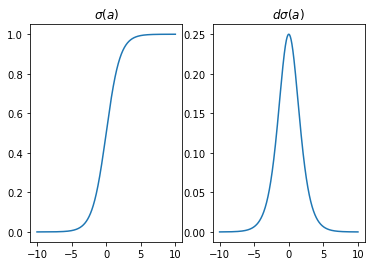

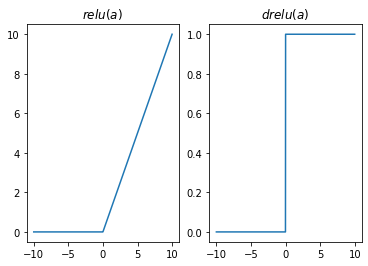

In [7]:
def sigmoid(a,deriv=False):
    # The sigmoid activation function 1/(1+exp(-a)) and its derivative
    #
    # Input: a - NxC matrix of values where each row of a corresponds to a single
    # input to the current layer with C units.
    # Output: s,ds
    #   s - NxC matrix of sigmoid function evaluated at the values in a
    #  ds - NxC matrix of the derivatives of the sigmoid evaluated at the values of a
    #
    # NOTE: you may only use basic exp/log functions from numpy here.  Only
    # np.exp, np.log, np.log1p, np.log1m, along with basic arithmetic are allowed
    # in your implementation.

    s  = 1/(1.0 + np.exp(-a))

    if deriv:
        ns = 1/(1.0 + np.exp( a))
        ds = s*ns

        return s, ds
    else:
        return s

def relu(a,deriv=False):
    # TODO: Implement the relu activation function max(a,0) and its derivative
    #
    # Input: a - NxC matrix of values where each row of a corresponds to a single
    # input to the current layer with C units.
    # Output: r,dr
    #   r - NxC matrix of function values at the values in a
    #  dr - NxC matrix of the derivatives of the relu evaluated at the values of a

    r = np.maximum(a,0)
    if deriv:
        dr = (r == a)*1

        return r, dr
    else:
        return r

def softmax(a,params=None,deriv=False):
    # TODO: Implement the softmax function s = exp(a)/sum(exp(a)) and its
    # Jacobian where J[i,j] = ds[i]/da[j] = -(s[i]*s[j]) if i!=j and
    # (s[i]*(1-s[i])) if i==j.
    #
    # Input: a - NxC matrix of values where each row of a corresponds to a single
    # input to the softmax function
    # Output: s,ds
    #   s - NxC matrix of softmax function values at the values in a
    #  ds - NxCxC tensor of Jacobians of the softmax function of each input

    N,C = a.shape

    c = np.amax(a,1).reshape(N,1)
    s = np.exp(a-c)/np.sum(np.exp(a-c), 1).reshape(N,1)
    if deriv:
        ds = np.array([np.diag(s[i]) - np.outer(s[i],s[i]) for i in range(N)]) # NEEDS BETTER EFFICIENCY!!!!!!!

        return s, ds
    else:
        return s

def identity(a,deriv=False):
    if deriv:
        return a, np.ones_like(a)
    else:
        return a

def crossent(y,yhat,deriv=False):
    # TODO: Implement the cross entropy loss L = -\sum_c (y==c) log(p(y==c)).
    #
    # Input: y,yhat
    #     y - Nx1 vector of class labels for N inputs
    #  yhat - NxC matrix of probabilities of each class c for each input i
    #         i.e., yhat[i,c] is p(y[i]==c)
    #
    # Output: l,dl
    #   l - Nx1 vector of cross entropy values
    #  dl - Nx1xC matrix of derivatives
    N,C = yhat.shape
    assert y.shape[0] == N

    p_correctlbl = (yhat[np.arange(N), y]).reshape(N,1)
    l = -np.log(p_correctlbl)
    if deriv:
        dl = onehot_encode(y, num_classes)*(-1/p_correctlbl)
        dl.reshape(N,1,C)

        return l,dl
    else:
        return l

def test_acts_impl():
    # These are sanity checks, not exhaustive unit tests.  These may pass but you
    # may still have bugs.  However, if these don't pass you almost certainly have
    # bugs.

    import scipy.special as spsp

    acts = [sigmoid,relu,softmax,identity]
    N = 2
    D = 5
    eps = 1e-8
    for _ in range(5):
        aval0 = np.random.randn(N,D)
        for afunc in acts:
            fval, dfval = afunc(aval0,deriv=True)
            # print(afunc) # uncomment this line to see which activation function is failing
            for i in range(D):
                aval_m = np.copy(aval0)
                aval_m[:,i] -= eps
                aval_p = np.copy(aval0)
                aval_p[:,i] += eps

            dfval_fd = (afunc(aval_p) - afunc(aval_m))/(2*eps)
            if dfval.ndim == 3:
                assert np.allclose(dfval_fd,dfval[:,:,i])
            else:
                assert np.allclose(dfval_fd[:,i],dfval[:,i])

    # unit test the sigmoid function
    eps = 1e-8
    avals = [-5,0.1,1]
    for a in avals:
        sa = sigmoid(a)

    assert np.all(sa > 0)
    assert np.all(sa < 1)
    assert np.abs(sa - spsp.expit(a)) < 1e-8

    # unit test the softmax function
    N = 2
    D = 5
    eps = 1e-8
    logitval0 = np.random.randn(N,D)
    s0 = softmax(logitval0)
    assert np.all(s0 >= 0)
    assert np.all(np.abs(1-np.sum(s0,axis=1))<1e-8)


    ina = np.linspace(-10,10,1000)
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(ina,sigmoid(ina,deriv=False))
    plt.title('$\sigma(a)$')
    plt.subplot(1,2,2)
    plt.plot(ina,sigmoid(ina,deriv=True)[1])
    plt.title('$d \sigma(a)$')

    ina = np.linspace(-10,10,1000)
    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(ina,relu(ina,deriv=False))
    plt.title('$relu(a)$')
    plt.subplot(1,2,2)
    plt.plot(ina,relu(ina,deriv=True)[1])
    plt.title('$d relu(a)$')

test_acts_impl()

# Implement forward pass and backprop

In [8]:
def nn_forward(x,acts,Theta):
    """
    Compute the forward pass of a neural network model for a set of inputs.

    Input: x,loss,acts,Theta,deriv
    x - NxD matrix of input vectors
    acts - list of length L of activation functions for each layer
    Theta - list of length L of the parameters of each layer.  In general, 
            Theta[i] = (Wi,bi) where Wi and bi are the weight matrix and bias 
            vector for layer i.

    Output: z
    z - an NxC matrix where C is the dimensionality of the output
    """
    N = x.shape[0]
    num_layers = len(acts)
    z = x

    for i in range(num_layers):
        act = acts[i] # activation function at this layer
        Wi,bi = Theta[i] # parameters at this layer 

        ai = (Wi @ z.T + bi).T
        z = act(ai,deriv=False)

    return z

def nn_loss(x,y,loss,acts,Theta,deriv=False):
    """
    Compute the objective function (and gradients) of the loss function for a set
    of data using a neural network model.

    Input: x,y,loss,acts,Theta,deriv
    x - NxD matrix of input vectors
    y - Nx1 vector of ground truth labels
    loss - function handle for the loss function
    acts - list of length L of activation functions for each layer
    Theta - list of length L of the parameters of each layer.  In general, 
            Theta[i] = (Wi,bi) where Wi and bi are the weight matrix and bias 
            vector for layer i.
    deriv - whether or not to compute and do the derivative

    Output: if deriv: E, dEdTheta, acc
              else: E, acc
    E - value of the loss function
    dEdTheta - the derivatives of the loss function for the parameters in Theta
               it has the same layout as Theta, specifically, 
                 dEdTheta[i] = (dEdWi,dEdbi) is the
               derivative of E with respect to the weight matrix and bias vector
               of layer i.
    acc - accuracy of predictions on the given data
    """
    N = x.shape[0]
    num_layers = len(acts)
    z = x

    zs = [] # input and output of each layer
    dzi_dais = [] # derivative of activation function of each layer
    for i in range(num_layers):
        act = acts[i] # activation function at this layer
        Wi,bi = Theta[i] # parameters at this layer 

        ai = (Wi @ z.T + bi).T
        if deriv:
            zs.append(z) # store input to the layer, needed for derivative wrt W

            z, dzi_dai = act(ai,deriv=True)
            dzi_dais.append(dzi_dai) # store derivative of activation function
        else:
            z = act(ai,deriv=False)

    maxc = np.argmax(z,axis=1) # Index of class with maximum probability
    acc = np.sum(maxc == y)/N

    if deriv:
        L, dLdz = loss(y,z,deriv=True)
        E = np.mean(L)

        dEdTheta = [None]*len(acts)

        # Initialize backprop with the gradients of the loss values wrt to the
        # output of the last layer
        # 
        # dLdzi has shape Nx1xDi where Di is the dimensionality of layer i because
        # we are treating it as the Jacobian of a function with 1 output
        dLdzi = (1.0/N)*dLdz

        # Backward pass
        for i in reversed(range(num_layers)):
            act = acts[i] # activation function at this layer
            Wi,bi = Theta[i] # parameters at this layer 
            zi_1 = zs[i] # input to the current layer
            dzi_dai = dzi_dais[i] # derivatives of layer activation function

            Di, Di_1 = Wi.shape
            # TODO: Backpropogate the derivative dLdzi through the activation function 
            # to compute dLdai.
            if dzi_dai.ndim == 2:
                # If dzi_dai only has two dimensions, then this activation function is 
                # element wise, so we only need to multiply each element of dLdzi with
                # it's corresponding derivative in dzi_dai.
                dLdai = (dLdzi * dzi_dai).reshape(N,1,Di)
            else:
                # If dzi_dai only has three dimensions, then this activation function is 
                # not elementwise and has a full Jacobian so we need to multiply the
                # jacobians dLzi[i] (a 1xDi matrix) and dzi_dai[i] (a DixDi matrix) for
                # each data point i.  For efficiency try to avoid looping by using the
                # @ operator and/or the np.matmul function.
                dLdai = (dLdzi.reshape(N,1,Di)) @ dzi_dai

            # TODO: Backpropogate the derivative dLdai through the linear
            # transformation to compute dLdzi for the next layer.
            dLdzi = (dLdai @ Wi).reshape(N,Di_1)

            # Derivatives of the parameters of the linear layer
            dEdW = np.sum(dLdai.reshape((N,Di,1)) * zi_1.reshape((N,1,Di_1)),axis=0)
            dEdb = np.sum(dLdai.reshape((N,Di)),axis=0).reshape((Di,1))
            dEdTheta[i] = (dEdW,dEdb)

        return E, dEdTheta, acc
    else:
        L = loss(y,z,deriv=False)
        E = np.mean(L)
        return E, acc


## Implement network training with GD

In [9]:
def nn_fit(train_x, train_y, val_x, val_y,
           opt_params, arch_params):
    """
    Train a neural network using gradient descent.

    Inputs: train_x, train_y, val_x, val_y, opt_params, arch_params
    train_x - NxD matrix of full training set with N samples and D dimensions
    train_y - Nx1 vector of training output values
    val_x, val_y - a validation set of samples to monitor performance
    opt_params - parameters of the training algorithm (see below)
    arch_params - parameters of the neural network architecture (see below)

    Outputs: Theta, stats
    Theta - parameters at the end of optimization
    stats - dictionary of various statistics computed during training to be used
            for visualization and analysis
    """

    # Optimization parameters in opt_params
    epsilon0 = opt_params['epsilon0'] # starting learning rate for GD
    epsilon_decay = opt_params['epsilon_decay'] # decay factor for GD learning rate
    epsilon_jump = opt_params['epsilon_jump'] # decay factor for GD learning rate
    num_its = opt_params['num_its'] # number of iterations to run
    Theta0 = opt_params['Theta0'] # initial value for the parameters, can be None to randomly initialize
    check_freq = opt_params['check_freq'] # how frequently to compute and print out statistics of learning
    print_checks = opt_params['print_checks'] # print info out when checkpointing
    seed = opt_params['seed'] if 'seed' in opt_params else 0

    if seed is not None:
        np.random.seed(seed)

    # Neural Network architecture parameters in arch_params
    num_hidden_layers = arch_params['num_hidden_layers'] # number of hidden layers
    num_hidden_units = arch_params['num_hidden_units'] # number of units per hidden layer (all layers are assumed to have the same number)
    num_outs = arch_params['num_outs'] # number of outputs, for classification the number of classes
    act_func = arch_params['act_func'] # hidden layer activation function
    out_func = arch_params['out_func'] # output layer activation function
    loss_func = arch_params['loss_func'] # loss function to use for training

    train_N, data_dim = train_x.shape

    assert num_hidden_layers >= 0
    acts = [act_func]*num_hidden_layers + [out_func]
    if Theta0 is None:
        # If no initial value of parameters is given, this randomly generates one.
        if num_hidden_layers > 1:
            Theta0 = [    (0.1*np.random.randn(num_hidden_units,data_dim),      np.zeros((num_hidden_units,1))) ] + \
                   [ (0.1*np.random.randn(num_hidden_units,num_hidden_units), np.zeros((num_hidden_units,1))) ]*(num_hidden_layers-1) + \
                   [    (0.1*np.random.randn(num_outs,num_hidden_units),              np.zeros((num_outs,1))) ]
        elif num_hidden_layers == 1:
            Theta0 = [ (0.1*np.random.randn(num_hidden_units,data_dim), np.zeros((num_hidden_units,1))) ] + \
                   [ (0.1*np.random.randn(num_outs,num_hidden_units),         np.zeros((num_outs,1))) ]
        elif num_hidden_layers == 0:
            Theta0 = [ (0.1*np.random.randn(num_outs,data_dim),   np.zeros((num_outs,1))) ]

    check_its = []
    check_times = []
    it_times = []
    data_pts = []
    check_data_pts = []
    check_Thetas = []
    train_losss = []
    train_accs = []
    val_losss = []
    val_accs = []
    epsilon = epsilon0
    start_t = time.time()
    num_data_proc = 0
    Theta = Theta0
    for it in range(num_its):
        # Compute loss and its derivative with current parameter values
        train_loss, dEdTheta, train_acc = nn_loss(train_x,train_y,loss_func,acts,Theta,deriv=True)
        num_data_proc += train_N

        # Find epsilon which decreases train loss
        epsilon *= epsilon_jump
        new_train_loss = np.inf
        while new_train_loss > train_loss:
            nrmsq_dEdTheta = 0
            Theta1 = []
            # Loop over all layers and update their parameters with the GD update
            for (Wi,bi),(dEdWi,dEdbi) in zip(Theta,dEdTheta):
                # TODO: Wi1 and bi1 should be the value of the parameters after the
                # gradient update based on the derivatives dEdWi,dEdbi, previous
                # parameter values Wi,bi and stepsize epsilon
                Wi1 = Wi - epsilon * dEdWi
                bi1 = bi - epsilon * dEdbi

                Theta1.append((Wi1,bi1))

                # Compute the norm of the entire gradient to monitor
                nrmsq_dEdTheta += np.sum(dEdWi**2) + np.sum(dEdbi**2)
            
            new_train_loss, new_train_acc = nn_loss(train_x,train_y,loss_func,acts,Theta,deriv=False)
            epsilon *= epsilon_decay

        # Replace old value of Theta with new one
        Theta = Theta1
        

        if it%check_freq == 0 or it+1 == num_its:
            # Periodically compute the training loss/accuracy on the _full_ dataset
            # for reference.  Note this is rarely done in practice because it isn't
            # possible or is hugely impractical.  We're just doing it here to see 
            # how it relates to the values computed with a mini-batch
            train_loss, train_acc = nn_loss(train_x,train_y,
                                       loss_func,acts,Theta,deriv=False)


            # Periodically compute the validation loss/accuracy for reference.
            val_loss, val_acc = nn_loss(val_x,val_y,
                                   loss_func,acts,Theta,deriv=False)

            check_Thetas.append(Theta)
            check_its.append(it)
            check_data_pts.append(num_data_proc)
            check_times.append(time.time() - start_t)
            train_losss.append(train_loss)
            train_accs.append(train_acc)
            val_losss.append(val_loss)
            val_accs.append(val_acc)
            if print_checks:
                print("{:4}: eps = {:.2e};"
                      "  train: loss = {:5.2f}, acc = {:.2f};"
                      "  val: loss = {:5.2f}, acc = {:.2f};"
                      "  ||dEdTheta|| = {:5.2f}".format(it, epsilon,
                                                        train_loss, train_acc,
                                                        val_loss, val_acc,
                                                        np.sqrt(nrmsq_dEdTheta)))
        data_pts.append(num_data_proc)
        it_times.append(time.time() - start_t)

    stats = { 'check_its':check_its, # Iteration numbers of checkpoints
            'check_times':check_times, # wall clock time of checkpoints
            'check_data_pts':check_data_pts, # number of training samples processed at check points
            'check_Thetas':check_Thetas, # Theta values at checkpoints
            'it_times':it_times, # wall clock time of each iteration
            'data_pts':data_pts, # number of training samples processed at each iteration
            'train_losss':train_losss, 'train_accs':train_accs, # loss and accuracy of full training set at checkpoint iterations
            'val_losss':val_losss, 'val_accs':val_accs } # loss and accuracy of validation set at checkpoint iterations
    return Theta, stats

## Train a network on the dataset

In [10]:
opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 1.5,
               'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None }
arch_params = { 'num_hidden_layers':0, 'num_hidden_units':5, 'num_outs':num_classes,
                'act_func':relu, 'out_func':softmax, 'loss_func':crossent }

Theta, stats = nn_fit(train_x, train_y, val_x, val_y,
                      opt_params, arch_params)

   0: eps = 7.50e-01;  train: loss =  9.47, acc = 0.49;  val: loss = 12.01, acc = 0.36;  ||dEdTheta|| =  4.81
   1: eps = 5.62e-01;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  4.09
   2: eps = 4.22e-01;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  0.00
   3: eps = 3.16e-01;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  0.00
   4: eps = 2.37e-01;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  0.00
   5: eps = 1.78e-01;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  0.00
   6: eps = 1.33e-01;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  0.00
   7: eps = 1.00e-01;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  0.00
   8: eps = 7.51e-02;  train: loss =  0.00, acc = 1.00;  val: loss =  0.00, acc = 1.00;  ||dEdTheta|| =  0.00
   9: eps 

## Visualize the training process with some plots

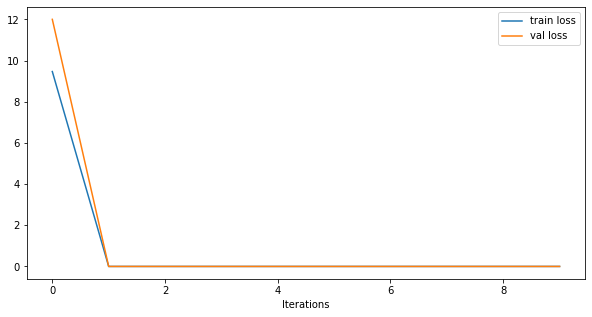

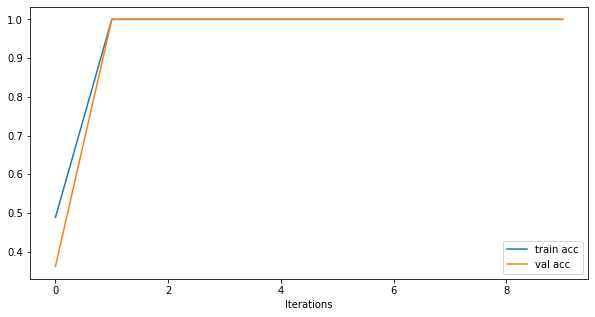

In [11]:
plt.figure(figsize=(10,5))
plt.plot(stats['check_its'],stats['train_losss'],label='train loss')
plt.plot(stats['check_its'],stats['val_losss'],label='val loss')
plt.xlabel('Iterations')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(stats['check_its'],stats['train_accs'],label='train acc')
plt.plot(stats['check_its'],stats['val_accs'],label='val acc')
plt.xlabel('Iterations')
plt.legend()

# Graph and graph filter for classification

## Each class's mean is an eigenvector of the graph

In [12]:
def mean_patterns(train_x, train_y, val_x, val_y, num_classes):
    # Obtain potential eigenvectors based on each class's mean form
    forms = {}
    for c in range(num_classes):
        forms[c] =  np.mean(train_x[train_y == c], axis=0)
        
    # Make graph fourier transform matrix from obtained eigenvectors
    F = np.array([forms[c] for c in range(num_classes)])
    
    # Calculate val_acc
    z = F @ (val_x.T)
    val_N = len(val_y)
    val_acc = np.sum(np.argmax(z, axis=0) == val_y)/val_N
     
    return F, val_acc

val_acc = 0.9827586206896551
Obtained forms/eigenvectors:


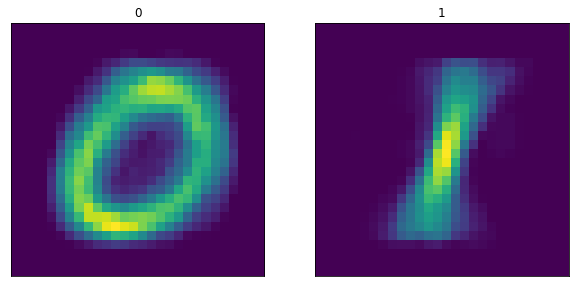

In [13]:
# Use mean patterns to classify digits
F, val_acc = mean_patterns(train_x, train_y, val_x, val_y, num_classes)

# Visualize results
print('val_acc = {}'.format(val_acc))
print('Obtained forms/eigenvectors:')
plt.figure(figsize=(10,5))
for c in range(num_classes):
    plt.subplot(1, num_classes, c+1)
    display_image(F[c], lbl=c)

In [14]:
Lambda = np.eye(num_classes)
G = (F.T) @ Lambda @ F

In [15]:
G1 = np.argmax(G, axis=1)

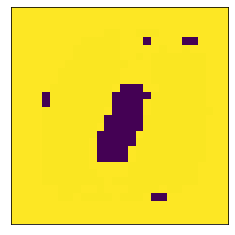

In [16]:
display_image(G1)
# plt.plot(12,22, 'ro') #node 628
# plt.plot(14,14, 'r*') #node 406
# plt.plot(15,8, 'r^') #node 211
# plt.plot(15,9, 'r+') #node 239

In [17]:
#G1.reshape(28,28)

In [18]:
G1_list = {}
for i in G1:
    if i not in G1_list:
        G1_list[i] = 0
    else:
        G1_list[i] = G1_list[i] + 1

In [19]:
G1_list

{628: 435, 627: 296, 406: 50}